# Import Modules
- Pandas 2.2.2
- NumPy 2.0.0
- XGBoost 2.1.0
- SciKit-Learn 1.5.1

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import Data
Load [Telco Churn Dataset](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset/data) from [IBM Base Samples](https://www.ibm.com/docs/en/cognos-analytics/12.0.0?topic=samples-telco-customer-churn).
- This dataset will allow us to predict if someone will stop using Telco's services or not using a variety of continuous and categorical datatypes. 

In [2]:
df = pd.read_excel('Data/Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


# Data Preparation
## Removing Unneeded Data
- `Churn Label`, `Churn Score`, `CLTV`, and `Churn Reason` are all exit interview answers that should not be used for training a machine learning model for predictive outputs.

In [3]:
exitInterviewColumns = ['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason']

# Set axis=0 to remove rows, axis=1 for columns.
df.drop(exitInterviewColumns, axis=1, inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


- Check if columns that **appear** to only have a single value, have unique values.

In [4]:
# Extension class to provide a quick way of checking uniqueness and avoiding verbosity.
class df_extensions:
  def __init__(self, df):
    self.df = df

  def is_unique(self, column_name):
    return len(self.df[column_name].unique()) > 1

df_ext = df_extensions(df)
print(f"Count: {df_ext.is_unique('Count')} || Country: {df_ext.is_unique('Country')} || City: {df_ext.is_unique('City')} || State: {df_ext.is_unique('State')}")

Count: False || Country: False || City: True || State: False


- Delete columns that returned `false` for uniqueness.
- Delete `CustomerId` column because it has no significance to the model.
- Delete `Lat Long` column because a `Latitude` and `Longitude` columns exist.

In [5]:
not_needed_cols = ['Count', 'Country', 'State', 'CustomerID', 'Lat Long']

df.drop(not_needed_cols, axis=1, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


- whitespaces are okay for XGBoost, but not for trees, so let's replace them with underscores in the column names and values.

In [6]:
df['City'].replace(' ', '_', regex=True, inplace=True)
df.columns = df.columns.str.replace(' ', '_')
df.head()

C:\Users\dleal\AppData\Local\Temp\ipykernel_17440\1018128565.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['City'].replace(' ', '_', regex=True, inplace=True)


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


## Handling Missing Data
- `XGBoost` has a default behavior for missing data, all that is needed to do is identify missing values and ensure they are set to `0`.

In [7]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

- `Total_Charges` should be purely numerical, however, we see it is type `object` which is a red flag.

In [8]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [9]:
# In theory, this should not fail because it should only contain numerical values.
# If exception is thrown, it will point us to the parsing error location.
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

ValueError: Unable to parse string " " at position 2234

- Check how many rows have a space in their `Total_Charges` column and display it.

In [11]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


- We can see the `Tenure_Months` are zero, meaning they have not been charged anything because they have not been at the company long enough.
  - We will set the `Total_Charges` to `0` for these scenarios and double-check the resulting dataframe.

In [12]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


- Convert the `Total_Charges` from object to a numerical type.

In [13]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

- Now that we have dealt with the empty spaces in `Total_Charges`, let's replace whitespaces with underscores everywhere else for the trees in XGBoost.

In [14]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


## Formatting Data
Split the data into two parts:
- The columns of data that will be used to make classifications (`X`)
- The columns of data that we want to predict (`y`)

In this dataset, `Churn Value` is going to represent the ultimate decision if a csutomer left.

In [15]:
# Remove the churn value since it is the prediction.
X = df.drop('Churn_Value', axis=1).copy()
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [16]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

## One-Hot Encoding
- A technique used to convert categorical variables into a numerical format that machine learning models can understand.

**Before One-Hot Encoding**
| ID | Favorite Color |
|----|----------------|
| 1  | Blue           |
| 2  | Green          |

**After One-Hot Encoding**
| ID | Blue | Green   |
|----|------|---------|
| 1  | 1    | 0       |
| 2  | 0    | 1       |

In [17]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

- Before committing to converting columns with `One-Hot Encoding`, let's take the payment method column as an example.
  1. We will first see the unique values used.
  2. We will use `pandas.get_dummies` on that column to see what the transformed dataframe will look like.
   

In [18]:
df['Payment_Method'].unique()

array(['Mailed_check', 'Electronic_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [19]:
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,False,False,False,True
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,False,False,True,False
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,False,False,True,False
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,False,False,True,False
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,True,False,False,False


- `get_dummies` has split `Payment_Method` column into four separate columns where if it was a `Bank_Transfer`, then that column is set to true and all others to false, for example.
- Now, we will apply this `One-Hot Encoding` to all of the columns that in the dataframe that are of type `object`.

In [20]:
X_encoded = pd.get_dummies(X, columns=['City',
                                       'Gender',
                                       'Senior_Citizen',
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support',
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,2,70.70,151.65,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
2,90006,34.048013,-118.293953,8,99.65,820.50,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
3,90010,34.062125,-118.315709,28,104.80,3046.05,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
4,90015,34.039224,-118.266293,49,103.70,5036.30,False,False,False,False,...,True,True,False,False,False,True,True,False,False,False


In [21]:
y.unique()

array([1, 0])

# Building an XGBoost Model
- It is important to note that the data is imbalanced. We can confirm this by dividing the number of people who left the company (y=1) by the total number of people in the dataset.

In [22]:
sum(y)/len(y)

0.2653698707936959

- We see only 27% of people left the company.
- We will split the data using stratification to maintain the same percentage in both the training and testing data.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

# Verify the stratrification worked as expected.
print(f"Training: {sum(y_train)/len(y_train)} || Testing: {sum(y_test)/len(y_test)}")

Training: 0.2654297614539947 || Testing: 0.26519023282226006


- Instead of determining the optimal number of trees with cross validation, we will use early stopping to stop building trees when they no longer improve the fitting.

In [27]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            missing=np.nan,
														seed=42,
														early_stopping_rounds=10,
                            eval_metric='aucpr')
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64135
[1]	validation_0-aucpr:0.65171
[2]	validation_0-aucpr:0.65991
[3]	validation_0-aucpr:0.65350
[4]	validation_0-aucpr:0.65743
[5]	validation_0-aucpr:0.65051
[6]	validation_0-aucpr:0.65827
[7]	validation_0-aucpr:0.65980
[8]	validation_0-aucpr:0.65751
[9]	validation_0-aucpr:0.65389
[10]	validation_0-aucpr:0.65572
[11]	validation_0-aucpr:0.65920
[12]	validation_0-aucpr:0.66010
[13]	validation_0-aucpr:0.65963
[14]	validation_0-aucpr:0.65877
[15]	validation_0-aucpr:0.65791
[16]	validation_0-aucpr:0.65808
[17]	validation_0-aucpr:0.65742
[18]	validation_0-aucpr:0.65770
[19]	validation_0-aucpr:0.65698
[20]	validation_0-aucpr:0.65733
[21]	validation_0-aucpr:0.65646


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

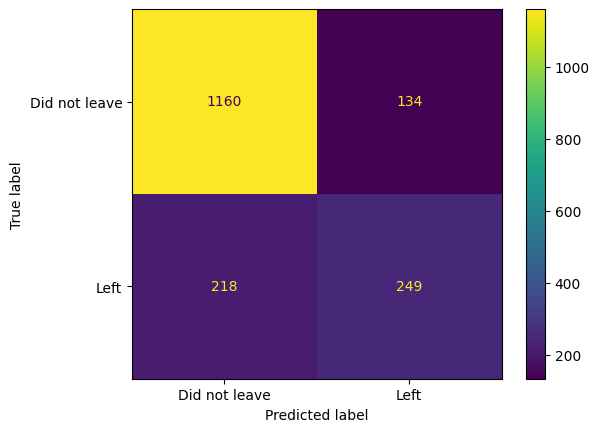

In [31]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Did not leave", "Left"])
disp.plot(values_format='d')

## Results
- 1160 out of 1294 (89.6%) correctly classified under `Did not leave`
- 218 out of 467 (53.3%) correctly classified under `Left`

The model **did not** perform too great...

## Hyper-Parameterization 
- `max_depth`: maximum tree depth
- `learning_rate`: learning rate
- `gamma`: parameter encouraging pruning
- `reg_lambda`: regularization parameter lambda
- `scale_pos_weight`: adds penalty for incorrect classification of minority class
  - XGBoost recommends sum(negative instances)/sum(positive instances)

In [35]:
param_grid = {
	'max_depth': [3, 4, 5],
	'learning_rate': [1, 0,5, 0.1, 0.01, 0.05],
	'gamma': [0, 0.25, 1.0],
	'reg_lambda': [0, 1.0, 10.0, 20, 100],
	'scale_pos_weight': [1, 3, 5]
}

# Speedup cross validation and prevent overfitting by using a random
# subset of data (90%) and random subset of features (50% of columns).
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
																missing=np.nan,
																seed=42,
																early_stopping_rounds=10,
																eval_metric='aucpr',
																subsample=0.9,
                                colsample_bytree=0.5),
		param_grid=param_grid,
		scoring='roc_auc',
		verbose=0,
		n_jobs=10,
		cv=3
)
optimal_params.fit(X_train,
                   y_train,
									 verbose=False,
									 eval_set=[(X_test, y_test)])

optimal_params.best_params_

{'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 10.0,
 'scale_pos_weight': 3}

In [38]:
opt_clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                gamma=1,
																seed=42,
                                learning_rate=0.1,
																max_depth=5,
																reg_lambda=10.0,
																scale_pos_weight=3,
																subsample=0.9,
																colsample_bytree=0.5,
																early_stopping_rounds=10,
																eval_metric='aucpr')
opt_clf_xgb.fit(X_train,
                y_train,
                verbose=True,
								eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.55489
[1]	validation_0-aucpr:0.60724
[2]	validation_0-aucpr:0.61535
[3]	validation_0-aucpr:0.62280
[4]	validation_0-aucpr:0.62404
[5]	validation_0-aucpr:0.63150
[6]	validation_0-aucpr:0.63439
[7]	validation_0-aucpr:0.63564
[8]	validation_0-aucpr:0.63599
[9]	validation_0-aucpr:0.63715
[10]	validation_0-aucpr:0.63804
[11]	validation_0-aucpr:0.64131
[12]	validation_0-aucpr:0.64347
[13]	validation_0-aucpr:0.64293
[14]	validation_0-aucpr:0.64527
[15]	validation_0-aucpr:0.65358
[16]	validation_0-aucpr:0.65725
[17]	validation_0-aucpr:0.65957
[18]	validation_0-aucpr:0.65952
[19]	validation_0-aucpr:0.66124
[20]	validation_0-aucpr:0.66289
[21]	validation_0-aucpr:0.66183
[22]	validation_0-aucpr:0.66157
[23]	validation_0-aucpr:0.66172
[24]	validation_0-aucpr:0.66138
[25]	validation_0-aucpr:0.66232
[26]	validation_0-aucpr:0.66227
[27]	validation_0-aucpr:0.66100
[28]	validation_0-aucpr:0.65877
[29]	validation_0-aucpr:0.65936


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

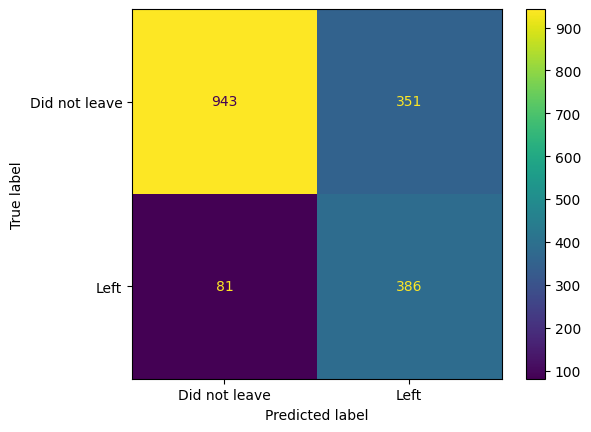

In [40]:
opt_y_pred = opt_clf_xgb.predict(X_test)
opt_cm = confusion_matrix(y_test, opt_y_pred)
opt_disp = ConfusionMatrixDisplay(opt_cm, display_labels=["Did not leave", "Left"])
opt_disp.plot(values_format='d')

## Hyper-Parameterized Results
- 943 out of 1294 (72.9%) correctly classified under `Did not leave`
- 386 out of 467 (82.7%) correctly classified under `Left`